In [1]:
import numpy as np
import quantecon as qe
from collections import namedtuple
from numba import njit, int32
import matplotlib.pyplot as plt

In [2]:
Model = namedtuple("Model", ("p", "s", "S"))

In [3]:
def create_inventory_model(S=100,  # Order size
                           s=10,   # Order threshold
                           p=0.4): # Demand parameter
    return Model(p=p, s=s, S=S)

In [4]:
@njit
def h(x, d, model):
    "The update rule for the model."
    s, S = model.s, model.S
    return max(x - d, 0) + S * (x <= s)

In [5]:
@njit
def phi_draw(model):
    """
    A function to sample from the geometric distribution 
    with parameter p, supported on 0, 1, ...
    """
    k = np.random.geometric(model.p)
    return k - 1  

In [6]:
@njit
def phi_pmf(k, model):
    """
    Returns P{X = k} where X is geometric with parameter p, 
    supported on 0, 1, ...
    """
    p = model.p
    return (1 - p)**k * p

In [7]:
@njit
def sim_inventories(model, ts_length=200):
    "Simulate the inventory process."
    X = np.empty(ts_length, dtype=int32)
    X[0] = model.S  # Initial condition

    for t in range(ts_length-1):
        X[t+1] = h(X[t], phi_draw(model), model)
    return X

In [8]:
@njit
def compute_mc(model, d_max=100):
    "Compute the transition probabilities and state."
    s, S, p = model.s, model.S, model.p
    n = S + s + 1  # Size of state space
    P = np.empty((n, n))
    for x in range(n):
        for y in range(n):
            prob = 0.0
            for d in range(d_max):
                prob += (h(x, d, model) == y) * phi_pmf(d, model)
            P[x, y] = prob

    return P

In [9]:
def compute_stationary_dist(model):
    "Compute the stationary distribution of the model."
    P = compute_mc(model)
    mc = qe.MarkovChain(P)
    return mc.stationary_distributions[0]

In [10]:
model = create_inventory_model()
state_values = np.arange(model.S + model.s + 1)

In [11]:
ψ_star = compute_stationary_dist(model) 
X = sim_inventories(model, ts_length=1_000_000)
histogram = [np.mean(X == i) for i in state_values]

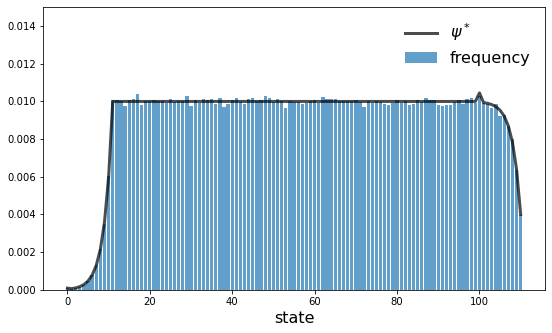

In [15]:
fontsize=16 
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(state_values, ψ_star, "k-",  
        lw=3, alpha=0.7, label="$\psi^*$")

ax.bar(state_values, histogram, alpha=0.7, label="frequency")
ax.set_xlabel("state", fontsize=fontsize)

ax.legend(fontsize=fontsize, frameon=False)
ax.set_ylim(0, 0.015)

plt.show()